# About

- In my [previous notebook](https://www.kaggle.com/hinepo/yolov8-finetuning-for-ppe-detection) I trained a Yolo v8 model to detect PPE (Personal Protective Equipment)
- And in this notebook I will use this model to detect and count how many people are inside a pre-determined Red Zone/Danger Zone
- Here I am combining two use cases: Red Zone counting + PPE detection
- This notebook and post-processing steps can also be used with results from a pretrained model with standard Yolo classes, or any other model that detects people. Just need to change the model's weights path
- [Ultralytics - docs](https://docs.ultralytics.com/)
- [Ultralytics - github](https://github.com/ultralytics/ultralytics)

Here you can see the workflow and steps I'm following, and its respective sections in this notebook.

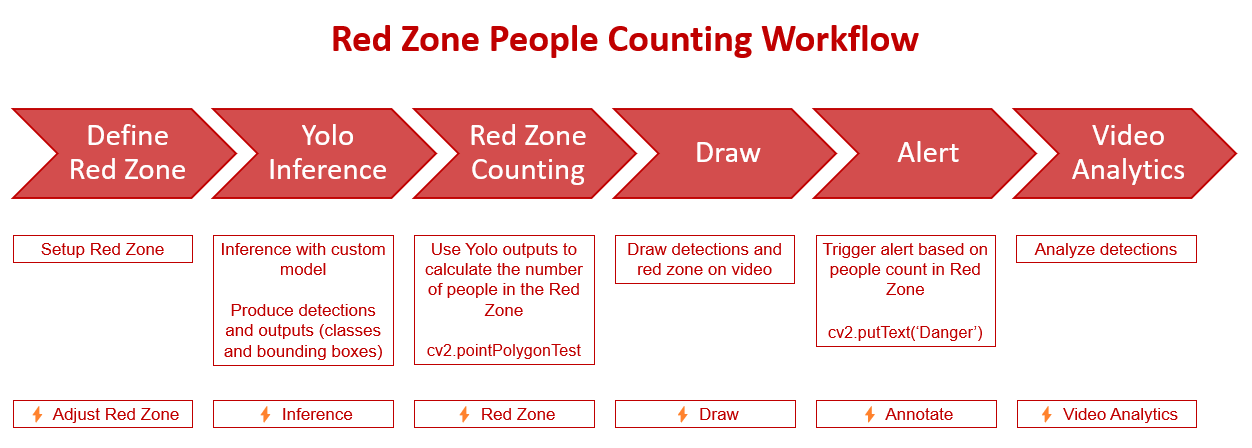

In [ ]:
! nvidia-smi -L

# Installs/Imports

In [ ]:
%%time

! pip install ultralytics -qq

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import yaml
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set3')

import IPython.display as display
from IPython.display import Video

from PIL import Image
import cv2

import torch

from ultralytics import YOLO

# CFG

In [ ]:
class CFG:
    ### inference: use any pretrained or custom model
    # WEIGHTS = 'yolov8x.pt' # yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
    WEIGHTS = '/kaggle/input/yolo-ppe-100-epochs/runs/detect/yolov8x_ppe_css_100_epochs/weights/best.pt'
    
    CONFIDENCE = 0.35
    CONFIDENCE_INT = int( round(CONFIDENCE * 100, 0) )
    
    CLASSES_TO_DETECT = [0, 2, 4, 5, 7] # Hardhat, NO-Hardhat, NO-Safety Vest, Person, Safety Vest
    
    VERTICES_POLYGON = np.array([[200,720], [0,700], [500,620], [990,690], [820,720]])

    EXP_NAME = 'ppe'

    ### just some video examples
    VID_001 = '/kaggle/input/video-example-for-ppe-red-zone/example_video.mp4'

    ### choose filepath to make inference on (image or video)
    PATH_TO_INFER_ON = VID_001
    EXT = PATH_TO_INFER_ON.split('.')[-1] # get file extension
    FILENAME_TO_INFER_ON = PATH_TO_INFER_ON.split('/')[-1].split('.')[0] # get filename

    ### paths
    ROOT_DIR = '/kaggle/input/video-example-for-ppe-red-zone/'
    OUTPUT_DIR = './'

In [ ]:
glob.glob(CFG.ROOT_DIR + '*')

## Image utils

In [ ]:
def get_image_properties(image):
    if isinstance(image, str):
        # If image is a file path, read the image
        img = cv2.imread(image)
        if img is None:
            raise ValueError("Could not read image file")
    elif isinstance(image, np.ndarray):
        # If image is already a NumPy array, use it directly
        img = image
    else:
        raise ValueError("Input must be a file path or a NumPy array")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img);
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')
        
    if hide_axis:
        plt.axis('off')
        
    plt.show()

## Video utils

In [ ]:
def get_video_properties(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        raise ValueError("Could not open video file")

    # Get video properties
    properties = {
        "fps": int(cap.get(cv2.CAP_PROP_FPS)),
        "frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        "duration_seconds": int( cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS) ),
        "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        "codec": int(cap.get(cv2.CAP_PROP_FOURCC)),
    }

    # Release the video capture object
    cap.release()

    return properties

In [ ]:
### testing function
video_properties = get_video_properties(CFG.VID_001)
video_properties

# 👀📽️ Video to make inference on

In [ ]:
OUT_VIDEO_NAME = './video_to_infer.mp4'

subprocess.run(
    [
        "ffmpeg",  "-i", CFG.PATH_TO_INFER_ON, "-crf",
        "18", "-preset", "veryfast", "-hide_banner", "-loglevel",
        "error", "-vcodec", "libx264", OUT_VIDEO_NAME
    ]
)

Video(data=OUT_VIDEO_NAME, embed=True, height=int(video_properties['height'] * 0.5), width=int(video_properties['width'] * 0.5))

# ⚡Adjust Red Zone

- Define ROI (Region of Interest, Red Zone, Danger Zone)
- Manually test and tune the Red Zone for your image or video
- After tuning polygon vertices, don't forget to update it in `CFG` section (VERTICES_POLYGON parameter)
- This will be used in `Annotate` section to post-process images and predictions, counting people in the Red Zone

In [ ]:
print('File path to make inference on: ', CFG.PATH_TO_INFER_ON)
print('File name to make inference on: ', CFG.FILENAME_TO_INFER_ON)

In [ ]:
cap = cv2.VideoCapture(CFG.PATH_TO_INFER_ON)

if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    # Read the first frame
    ret, frame_test = cap.read()
    cap.release()

vertices_polygon = np.array([[200,720], [0,700], [500,620], [990,690], [820,720]]) # manually adjusted

cv2.polylines(frame_test, [vertices_polygon.reshape(-1, 1, 2)], True, (0, 0, 128), 4)

mod = frame_test.copy()
overlay = cv2.fillPoly(mod, pts = [vertices_polygon], color=(0, 0, 128))
background = frame_test.copy()

frame_test = cv2.addWeighted(
    src1 = background, # fisrt image
    alpha = 0.6, # first image weight
    src2 = overlay, # second image
    beta = 0.4, # second image weight
    gamma = 0.1, # scalar factor
    dst = overlay # output array shape
)

In [ ]:
display_image(frame_test)

In [ ]:
img_properties = get_image_properties(frame_test)
img_properties

After tuning the polygon vertces, just update them in CFG class.

# Model

With Yolo v8 API you can easily run inference on any task:
  - Detection
  - Segmentation
  - Classification
  - Pose estimation

You can also make inference with any pre-trained Yolo model or any Custom model you've trained before.

For any of these changes, just change the model name when instantiating the YOLO object.

The post-processing section in this notebook is designed to clean and manipulate the outputs from the object detection task.

In [ ]:
model = YOLO(CFG.WEIGHTS)

In [ ]:
print('Device: ', model.device)

In [ ]:
if torch.cuda.is_available():
    model.to('cuda:0')
else:
    print("CUDA device is not available. Running on CPU.")

In [ ]:
print('Device: ', model.device)
print('Weights: ', CFG.WEIGHTS)

In [ ]:
# model.model
model.names

# ⚡Inference

- We can use multiple GPUs to make inference

In [ ]:
%%time

results = model.predict(
    source = CFG.PATH_TO_INFER_ON,
    save = True,
    classes = CFG.CLASSES_TO_DETECT,
    conf = CFG.CONFIDENCE,
    save_txt = True,
    save_conf = True,
    show = True,
    device = [0,1],
#     stream = True,
)

# 👀📽️ Raw inference video

- Visualize the inference results from the custom model
- No post-processing done yet

In [ ]:
RAW_INFERENCE_VIDEO = glob.glob('/kaggle/working/runs/detect/predict/example_video*')[0] # avi or mp4
OUT_VIDEO_NAME = './raw_inference.mp4'

subprocess.run(
    [
        "ffmpeg",  "-i", RAW_INFERENCE_VIDEO, "-crf",
        "18", "-preset", "veryfast", "-hide_banner", "-loglevel",
        "error", "-vcodec", "libx264", OUT_VIDEO_NAME
    ]
)

Video(data=OUT_VIDEO_NAME, embed=True, height=int(video_properties['height'] * 0.5), width=int(video_properties['width'] * 0.5))

The raw inference looks pretty good.

It is common to get some False Positives in computer vision systems, especially in a case like this where the model that hasn't been trained on the video specific scenario. This can also be mitigated tuning the confidence threshold for the inference (CFG class).

The lower the confidence threshold, the more objects will be detected, and also more False Positives will arise.

So one thing we can do next is to apply some empiric rules to the detections dataframe and try to reduce the number of False Positives. Then, we post-process the video using this new dataframe, annotating the detections.

This isn't always necessary but tuning the confidence threshold and post-processing steps can certainly increase Precision and Recall.

Setting up a good threshold also has high impact in the Red Zone application counting.

In [ ]:
raw_inference_video_properties = get_video_properties(RAW_INFERENCE_VIDEO)
raw_inference_video_properties

# Get predictions

- For Detection task
- Concatenate all txt files (predicted labels) from all images/videos we inferred
- Build a dataframe with predictions from Yolo

In [ ]:
def get_predictions_df_for_videos(run = '', model = model, EXP_NAME = CFG.EXP_NAME, video_info = video_properties, save_df = True):
  df = pd.DataFrame()

  root = f'./runs/detect/predict{run}/labels/'
  pieces = sorted([i for i in os.listdir(root)])

  ### iterate over txt files (there is one for each frame in the video)
  for i, frame_txt in enumerate([i for i in pieces]):

    df = pd.read_csv(root + frame_txt, sep=" ", header=None) # read txt file as dataframe
    df.columns = ["class", "x_center", "y_center", "width", "height", "confidence"] # name columns (detection task)

    ### create column 'frame'
    frame_number = re.findall(r'\d+', frame_txt)[-1] # find frame in each txt filename
    df['frame'] = [int(frame_number) for i in range(len(df))]

    if i == 0:
      df_concat = df
    else:
      df_concat = pd.concat([df_concat, df], axis=0).reset_index(drop=True)

  ### create 4 new columns (coordinates converted into pixels): Calculate bounding box coordinates
  df_concat['x_min'] = (df_concat['x_center'] * video_info['width']) - ((df_concat['width'] * video_info['width'])/2)
  df_concat['x_max'] = (df_concat['x_center'] * video_info['width']) + ((df_concat['width'] * video_info['width'])/2)
  df_concat['y_min'] = (df_concat['y_center'] * video_info['height']) - ((df_concat['height'] * video_info['height'])/2)
  df_concat['y_max'] = (df_concat['y_center'] * video_info['height']) + ((df_concat['height'] * video_info['height']/2))

  ### create 2 new columns: height and width in pixels: will be used to filter out bad predictions (false positives)
  df_concat['width_px'] = (df_concat['width'] * video_info['width']).round(0).astype(int)
  df_concat['height_px'] = (df_concat['height'] * video_info['height']).round(0).astype(int)

  ### sort by frame
  df_concat = df_concat.sort_values(by='frame', ascending=True).reset_index(drop=True)

  ### add column 'class_name' and rearrange order
  df_concat['class_name'] = df_concat['class'].map(model.names)
  other_cols = [col for col in df_concat.columns.to_list() if col not in ['frame', 'class_name', 'class', 'confidence' ]]
  new_order = ['frame', 'class_name', 'class', 'confidence'] + other_cols
  df_concat = df_concat[new_order]

  ### export detections df
  if save_df:
    df_concat.to_csv(CFG.OUTPUT_DIR + f'detections_{CFG.EXP_NAME}_c{CFG.CONFIDENCE_INT}.csv', index=False)

  return df_concat

In [ ]:
out_df = get_predictions_df_for_videos(
    run = '',
    model = model,
    EXP_NAME = CFG.EXP_NAME,
    video_info = video_properties,
    save_df = False
)

out_df

# Post-process predictions

Reduce number of False Positives based on rules that depend on specific characteristics of the images/videos:
  - Environmental factors
  - Context, scenarios
  - Lighting conditions
  - Background
  - Scale, size, distance, viewpoint, perspective

Filter out bad predictions based on the context of the image/video.

In [ ]:
def post_process_predictions_df(predictions_df, video_info = video_properties, EXP_NAME = CFG.EXP_NAME, save_df = True):

  df = predictions_df.copy()

  min_person_height = 250
  max_person_width = 620

  img_width = video_properties['width']
  img_height = video_properties['height']

  ### filter out False Positives based on new columns
  df_false_positives1 = df[ (df['height_px'] <= min_person_height) & (df['class_name'] == 'Person') ]
  df_false_positives2 = df[ (df['width_px'] >= max_person_width) & (df['class_name'] == 'Person') ]
  df_false_positives = pd.concat([df_false_positives1, df_false_positives2], axis=0)
  merged = df.merge(df_false_positives, how='left', indicator=True)
  df = merged[merged['_merge'] == 'left_only']
  df = df.drop('_merge', axis=1)
  df = df.reset_index(drop=True)
    
  print('out_df (raw detections) shape: ', out_df.shape)
  print('df_false_positives1: ', df_false_positives1.shape)
  print('df_false_positives2: ', df_false_positives2.shape)
  print('pp_df (post-processed detections) shape: ', df.shape, '\n')    

  ### export detections df
  if save_df:
    df.to_csv(CFG.OUTPUT_DIR + f'detections_{CFG.EXP_NAME}_c{CFG.CONFIDENCE_INT}.csv', index=False)

  return df

In [ ]:
pp_df = post_process_predictions_df(
    out_df,
    video_info = video_properties,
    EXP_NAME = CFG.EXP_NAME,
    save_df = False
)

pp_df

I encourage you to take a close look at this dataframe and reflect on how it can be used to post-process predictions and detections in different downstream applications.

# Detections statistics

- These plots can provide valuable information on how confident our model is at predicting each of the classes
- This can be used to tune the confidence threshold on inference videos
- If our custom dataset is similar in train/validation/test/production sets, as it ideally should, we can also tune the confidence threshold using the training plots (Recall-Confidence curve, Precision-Confidence curve, Precision-Recall curve and f1-Confidence curve)

In [ ]:
ax = pp_df['class_name'].value_counts().plot(kind='bar')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.xlabel('Class Name')
plt.ylabel('Count')
plt.title('Number of detections in video, per class')
plt.show()

Looks like the model is indeed detecting the classes that are present in the video.

In [ ]:
### median confidence for each class
### this can help tuning the confidence threshold
pp_df.groupby('class_name').confidence.median().round(3).sort_values(ascending=False)

In [ ]:
### distribution of confidence scores for each class
grouped = pp_df.groupby('class_name')

colors = ['green', 'red', 'pink', 'blue', 'lime']

plt.figure(figsize=(10, 6))

for i, (group_name, group_data) in enumerate(grouped):
    plt.hist(group_data['confidence'], bins=10, alpha=0.5, label=group_name, color=colors[i])

plt.xlabel('Confidence scores')
plt.ylabel('Frequency')
plt.title('Confidence distributions for different Classes')
plt.axvline(x=CFG.CONFIDENCE, linestyle='dashed', color='red')
plt.legend()
plt.grid(True)
plt.show()

This shows how much confidence our model has at predicting each of the classes.

This is tighly linked to which classes are present in the video, to the chosen inference threshold and to the degree of (dis)similarity between the images in the training dataset and the images in the video we made inference on.

This is an important information and helps us to adjust our training dataset, improving the quality of the images and labels of the classes that the model hasn't learned well yet.

# ⚡Red Zone

- ROI: Region of Interest, Red Zone, Danger Zone, Risk Area
- For a given frame of the video, count how many people are in and out of the Red Zone
- Polygon is automated with vertices defined in `CFG` class

In [ ]:
def count_people_in_red_zone(frame_number, img, detections_dataframe, vertices=CFG.VERTICES_POLYGON):
    '''
    For a given frame (img) of the video, count how many people are in and out of the Red Zone.
    Check position in/out of the Red Zone only for Person class. Don't check other classes.

    Args:
    - frame_number: The frame number to process.
    - img: The frame image.
    - detections_dataframe: DataFrame containing detection information for all frames.
    - vertices: List of vertices defining the Red Zone polygon.

    Returns:
    - total_person_count: Total number of people in the frame.
    - count_person_in_roi: Number of people inside the Red Zone.
    - combined_df: Combined DataFrame with additional columns indicating if each person is in the Red Zone.
    '''

    count_person_in_roi = 0
    count_person_out_roi = 0

    frame_data = detections_dataframe[detections_dataframe['frame'] == frame_number].copy()

    if not frame_data.empty:
        frame_data['is_person_in_roi'] = 0  # Create a new column

        for i, row in frame_data.iterrows():
            if row['class_name'] == 'Person':
                foot_1 = (row['x_min'], row['y_max'])
                foot_2 = (row['x_max'], row['y_max'])

                # Draw little circles on each foot (orange)
                cv2.circle(img, np.array(foot_1).astype(int), 3, (0, 165, 255), -1)
                cv2.circle(img, np.array(foot_2).astype(int), 3, (0, 165, 255), -1)

                # Check if the foot is inside the polygon
                inside1 = cv2.pointPolygonTest(np.array([vertices]), foot_1, False)
                inside2 = cv2.pointPolygonTest(np.array([vertices]), foot_2, False)

                # 1: inside; 0: on border; -1: outside
                if inside1 == 1 or inside2 == 1:
                    count_person_in_roi += 1
                    frame_data.at[i, 'is_person_in_roi'] = 1
                else:
                    count_person_out_roi += 1

        # Calculate the total number of people in the frame
        total_person_count = len(frame_data[frame_data['class_name'] == 'Person'])

        # Create columns in the output DataFrame
        frame_data['person_count_in_roi'] = count_person_in_roi
        frame_data['person_count_out_roi'] = count_person_out_roi

        # Fill missing values with 0
        combined_df = frame_data.fillna(0)

        return total_person_count, count_person_in_roi, combined_df

    else:
        return 0, 0, frame_data

# ⚡Draw

- Draw Bounding Boxes and Red Zone
- Take the output (dataframe) from the red zone function (count_people_in_red_zone) and use it to annotate the predictions on the frame (img)

In [ ]:
def draw_bounding_boxes_and_red_zone(df_coords, img, vertices = CFG.VERTICES_POLYGON, thickness=4, show_mask=True):
    '''
    Draw bounding boxes based on coordinates df, and set bbox colors.
    Draw Red Zone based on CFG.

    df_coords: detections dataframe produced by Yolo, already post-processed and then treated in red_zone_pipeline
    img: frame on which the bounding boxes (coordinates in df_coords) will be drawn
    '''

    ### person post-processing
    person_df = df_coords[df_coords['class_name'] == 'Person'].reset_index(drop=True)
    for i, person_detected in person_df.iterrows():

        # top left corner of rectangle
        start_point = ( int(person_detected['x_min']), int(person_detected['y_max']) )

        # bottom right corner of rectangle
        end_point = ( int(person_detected['x_max']), int(person_detected['y_min']) )

        if person_detected['is_person_in_roi'] == 1:
            cv2.rectangle(img, start_point, end_point, (0,0,128), thickness) # BGR maroon: in danger
        else:
            cv2.rectangle(img, start_point, end_point, (255,191,0), thickness) # BGR deepskyblue: not in danger

    ### Hardhat post-processing
    hardhat_df = df_coords[df_coords['class_name'] == 'Hardhat'].reset_index(drop=True)
    for i, hardhat_detected in hardhat_df.iterrows():

        # top left corner of rectangle
        start_point = ( int(hardhat_detected['x_min']), int(hardhat_detected['y_max']) )

        # bottom right corner of rectangle
        end_point = ( int(hardhat_detected['x_max']), int(hardhat_detected['y_min']) )

        cv2.rectangle(img, start_point, end_point, (0,128,0), thickness) # BGR, green

    ### Safety-Vest post-processing
    safety_vest_df = df_coords[df_coords['class_name'] == 'Safety Vest'].reset_index(drop=True)
    for i, safety_vest_detected in safety_vest_df.iterrows():

        # top left corner of rectangle
        start_point = ( int(safety_vest_detected['x_min']), int(safety_vest_detected['y_max']) )

        # bottom right corner of rectangle
        end_point = ( int(safety_vest_detected['x_max']), int(safety_vest_detected['y_min']) )

        cv2.rectangle(img, start_point, end_point, (0,255,0), thickness) # BGR, lime

    ### NO-Hardhat and NO-Safety-Vest post-processing
    no_PPE_df = df_coords[df_coords['class_name'].isin(['NO-Hardhat', 'NO-Safety Vest'])].reset_index(drop=True)
    for i, no_PPE_detected in no_PPE_df.iterrows():

        # top left corner of rectangle
        start_point = ( int(no_PPE_detected['x_min']), int(no_PPE_detected['y_max']) )

        # bottom right corner of rectangle
        end_point = ( int(no_PPE_detected['x_max']), int(no_PPE_detected['y_min']) )

        cv2.rectangle(img, start_point, end_point, (0,255,255), thickness) # BGR, yellow

    ### show mask (Red Zone)
    if show_mask:
        cv2.polylines(img, [vertices.reshape(-1,1,2)], True, (0,0,128), 4) # maroon

        mod = img.copy()
        overlay = cv2.fillPoly(mod, pts = [vertices], color=(0,0,128)) # maroon
        background = img.copy()

        img = cv2.addWeighted(
            src1 = background, # first image
            alpha = 0.6, # first image weight
            src2 = overlay, # second image
            beta = 0.4, # second image weight
            gamma = 0.1, # scalar factor
            dst = overlay # output array shape
        )    

    return img

# ⚡Annotate

For each frame in the video:
  - Count people in and out of Red Zone
  - Aggregate count by seconds
  - Draw Bounding Boxes and Red Zone
  - Trigger alert ('Danger')

Then, save the aggregated dataframe with Red Zone People count per second and the post-processed video

In [ ]:
%%time
cap = cv2.VideoCapture(CFG.PATH_TO_INFER_ON)

save_exp = True
log = False

### Parameters to save video
if save_exp:
    ### save path and config for saving
    save_path_video = f'{CFG.OUTPUT_DIR}red_zone_det_vid_c{CFG.CONFIDENCE_INT}_{CFG.EXP_NAME}_{CFG.FILENAME_TO_INFER_ON}_pp.mp4'

    out = cv2.VideoWriter(
        save_path_video,
        cv2.VideoWriter_fourcc(*'XVID'),
        video_properties['fps'],
        (video_properties['width'], video_properties['height'])
    )

### create timestamp dataframe from frames dataframe
frame_count = video_properties['frame_count']
fps = video_properties['fps']
print('N frames: ', int(frame_count), '| FPS: ', int(fps))
list_timestamps = [second for second in range(int(frame_count/fps))] # list of timestamps
complete_frame_df = pd.DataFrame() # initialize frame_df

frame_number = 0
outputs_list = []

while cap.isOpened():
    frame_exists, frame = cap.read()

    ### get Timestamp (ts) to create timestamp_df
    ts = int(cap.get(cv2.CAP_PROP_POS_MSEC)) # Current position of the video file in milliseconds
    if log:
        print("Frame: " + str(frame_number) + "timestamp is: ", str(round(ts,2)))

    if not frame_exists:
        print("\nCan't receive frame (stream end?). Exiting...\n")
        break

    ### Count People in Red Zone
    count_person, count_person_roi, frame_df = count_people_in_red_zone(
        frame_number = frame_number,
        img = frame,
        detections_dataframe = pp_df,
        vertices = CFG.VERTICES_POLYGON
    )

    ### store results
    outputs_list.append([ts, frame_number, count_person, count_person_roi])
    complete_frame_df = pd.concat([complete_frame_df, frame_df], axis=0) # update (concat frames)


    ### Aggregate risk detections by seconds to create timestamp_df
    if int(ts/1000) in list_timestamps:
        idx = list_timestamps.index(int(ts/1000))

        ### get the max value of number of people detected on last second
        if idx == 0: # idx = 0 : first frame
            count_person_roi_agg = count_person_roi
        else: # idx > 0
            lower_cut = int(fps * list_timestamps[idx-1])
            upper_cut = int(fps * list_timestamps[idx])
            output_chunk_list = np.array(outputs_list[lower_cut:upper_cut])
            count_person_roi_agg = int(output_chunk_list[:,3].max()) # 3: count_person_roi output


    ### draw bounding boxes and red zone
    frame = draw_bounding_boxes_and_red_zone(
        df_coords = frame_df,
        img = frame,
        vertices = CFG.VERTICES_POLYGON,
        thickness = 4,
        show_mask = True,
    )

    ### print Danger
    h, w, c = frame.shape
    if count_person_roi_agg:
        cv2.putText(
            img = frame,
            text = f'Danger: {count_person_roi_agg}',
            org = ( w - (int(w/3)), h - (h - int(h/6)) ), # bottom-left corner of the text
            fontFace = cv2.FONT_HERSHEY_PLAIN,
            fontScale = 3, # 3,
            color = (0,0,128), # maroon
            thickness = 3
        )
    else:
        cv2.putText(
            img = frame,
            text = f'Danger: {count_person_roi_agg}',
            org = ( w - (int(w/3)), h - (h - int(h/6)) ), # bottom-left corner of the text
            fontFace = cv2.FONT_HERSHEY_PLAIN,
            fontScale = 3, # 3,
            color = (255,191,0), # deepskyblue
            thickness = 3
        )


    ### save frame with detections post-processed
    if save_exp:
        out.write(frame)

    ### Update Frame
    frame_number += 1

cap.release()
if save_exp:
    out.release()
    print('\nVideo saved in: ', save_path_video)
    print('\n\n')
# cv2.destroyAllWindows()

### adjust dtypes and save complete_frame_df
complete_frame_df['is_person_in_roi'] = complete_frame_df['is_person_in_roi'].fillna(0).astype(int)
complete_frame_df['person_count_in_roi'] = complete_frame_df['person_count_in_roi'].fillna(0).astype(int)
complete_frame_df['person_count_out_roi'] = complete_frame_df['person_count_out_roi'].fillna(0).astype(int)
complete_frame_df.to_csv(CFG.OUTPUT_DIR + f'df_frame_PRD_c{CFG.CONFIDENCE_INT}_{CFG.EXP_NAME}_{CFG.FILENAME_TO_INFER_ON}.csv', index=False)

### export dataframe with detections per frame
timestamp_df = pd.DataFrame(data = outputs_list, columns=['ts_milliseconds', 'frame_number', 'person_total', 'person_in_roi'])
timestamp_df.to_csv(CFG.OUTPUT_DIR + f'df_ts_PRD_c{CFG.CONFIDENCE_INT}_{CFG.EXP_NAME}_{CFG.FILENAME_TO_INFER_ON}.csv', index=False)
timestamp_df

In [ ]:
timestamp_df.hist(column = ['person_total', 'person_in_roi'], figsize = (14,4), layout = (1,4));

In [ ]:
complete_frame_df

# 👀📽️ Final video

Combining two applications:
- Detect PPE (Person, Hardhat, NO-Hardhat, Safety Vest, NO-Safety Vest)
- Count people in the Red Zone

Classes:
- Person in Red Zone: maroon
- Person not in Red Zone: deepskyblue
- Hardhat: green
- Safety Vest: lime
- No-Safety Vest: yellow
- No-Hardhat: yellow

In [ ]:
OUT_VIDEO_NAME = './pp_inference.mp4'

subprocess.run(
    [
        "ffmpeg",  "-i", save_path_video, "-crf",
        "18", "-preset", "veryfast", "-hide_banner", "-loglevel",
        "error", "-vcodec", "libx264", OUT_VIDEO_NAME
    ]
)

Video(data=OUT_VIDEO_NAME, embed=True, height=int(video_properties['height'] * 0.5), width=int(video_properties['width'] * 0.5))

In [ ]:
final_video_properties = get_video_properties(OUT_VIDEO_NAME)
final_video_properties

# ⚡Video Analytics

- Create a dataframe with detections per seconds
- Plot statistics about the Red Zone and detections

In [ ]:
glob.glob(CFG.OUTPUT_DIR + '/*_ts_*.csv')[0]

In [ ]:
path_detections_per_milliseconds = glob.glob(CFG.OUTPUT_DIR + '/*_ts_*.csv')[0] # timestamp_df path
df_detections_per_sec = pd.read_csv(path_detections_per_milliseconds)

fps = video_properties['fps']
seconds_agg = 1
rows_agg = fps * seconds_agg

df_detections_per_sec['ts_seconds'] = df_detections_per_sec['ts_milliseconds']/1000 # create column timestamp in seconds

agg_col = [x for x in range(0, len(df_detections_per_sec), fps) for i in range(fps)]

df_detections_per_sec['frame'] = agg_col[:len(df_detections_per_sec)] # create column step size (aggregation)

df_plot = (
    df_detections_per_sec.groupby(['frame'])
    .agg(
        {
            'person_total' : ['mean','max'],
            'ts_seconds' : 'min',
            'person_in_roi' : ['mean','max']
        }
    )
  ).reset_index()

df_plot.columns = ['_'.join(x) for x in df_plot.columns]
df_plot = df_plot.rename(columns = {'frame_' : 'frame'})

new_order = ['ts_seconds_min', 'frame', 'person_total_mean', 'person_total_max', 'person_in_roi_mean', 'person_in_roi_max']
df_plot = df_plot[new_order]
df_plot['ts_seconds_min'] = df_plot['ts_seconds_min'].astype(int)
    
df_plot = df_plot.round(2)
df_plot

In [ ]:
print('out_df shape: ', out_df.shape) # raw predictions
print('pp_df shape: ', pp_df.shape) # post-processed predictions

print('complete_frame_df shape: ', complete_frame_df.shape) # frame key, class, coordinates
print('timestamp_df shape: ', timestamp_df.shape) # timestamp key, roi_in, roi_out
print('df_plot shape: ', df_plot.shape) # MAV, aggregation to plot

In [ ]:
def plot_video_analysis(df_plot, title, mav=False, video_properties = final_video_properties):

  cols = ['person_total_mean',  'person_total_max', 'person_in_roi_mean',  'person_in_roi_max']

  fig, ax = plt.subplots(2, 2, figsize = (30, 14))
  line, col = 0, 0

  for var in cols:

    ax_id = ax[line, col]

    if mav:

      df_plot[f'{var}_MAV'] = df_plot[var].rolling(mav).mean().replace(np.nan, 0).round(0).astype(int)

      ax_id.bar(df_plot['ts_seconds_min'], df_plot[f'{var}_MAV'])

      ax_id.axhline(1, color='red', linestyle='--')
      ax_id.axhline(2, color='red', linestyle='--')
      ax_id.axhline(3, color='red', linestyle='--')

    ax_id.set_ylabel('', fontsize=16)

    title_ax = ' '.join(var.split('_'))
    ax_id.set_title(title_ax, fontsize=16, weight=600)
    ax_id.set_xlabel('Time (s)', fontsize=16)
    #ax_id.legend()
    ax_id.set_yticks([0,1,2,3])
    ax_id.set_xlim(0, video_properties['duration_seconds'])

    line = line + 1 if col == 1 else line
    col = col + 1 if col < 1 else 0

  plt.suptitle(title, fontsize=18, y=1.02, fontweight='bold')

  # plt.tight_layout(1.2)

In [ ]:
### mav: moving average: window size of moving average
plot_video_analysis(df_plot, title = 'Detected People Frequency (s)', mav = 2, video_properties = final_video_properties)

# Conclusions

- Despite the domain shift between CSS dataset and the video we made inference on, the YOLO model trained on CSS dataset still was able to perform well, detecting accurately the classes that actually appear in the video: Person, Hardhat, NO-Safety Vest
- You can quickly check this domain shift by yourself if you take a look at the [images in the Roboflow CSS dataset](https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true), filter by class, and compare it to our 'production video'
- To improve the model, ideally we should collect data (images/videos) from our specific use case and label them, so the model can learn unique characteristics from our setup, environment, scenario, camera angle, perspective, background, lighting conditions etc.
- **We should always aim to build or leverage a custom dataset with diverse images that are representative of the scenarios and situations that the model will face when put into production**
- A more representative and better quality dataset (images and labels) will surely lead to much better accuracy and detections
- Situations where we want to detect a pre-determined set of objects in a fixed camera and controlled environment setup are the most suitable for labeling images and developing a custom dataset. In these cases the model will encounter more predictable conditions in production (matching better what is has seen during training) and will be able to benefit the most from a well prepared data
- There are still tasks and scenarios where a model finetuned on a generic and publicly available dataset can still provide good enough performance
- You can use this model I trained. I made the weights available [here](https://www.kaggle.com/datasets/hinepo/yolo-ppe-100-epochs)
- Upvote if you liked it!

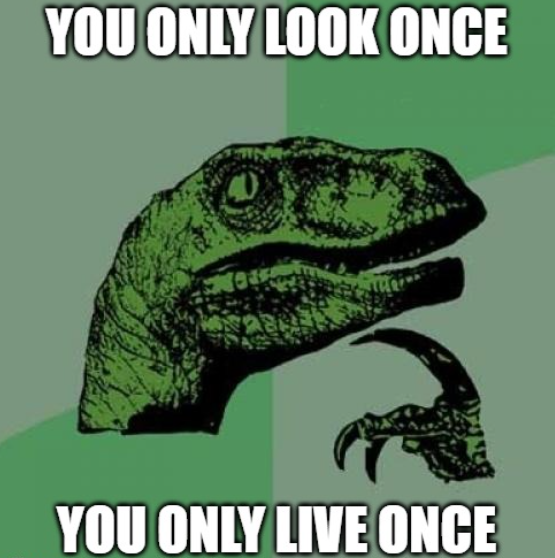

## submission 

In [1]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from ultralytics import NAS
from matplotlib.patches import Rectangle
import glob
import cv2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
INPUT_DIR = '/kaggle/input/godsensi/data'
WORK_DIR = '/kaggle/working/'

In [4]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [5]:
model = YOLO('/kaggle/input/yolo-ppe-100-epochs/runs/detect/yolov8x_ppe_css_100_epochs/weights/best.pt') 
#/kaggle/input/construction-site-safety-image-dataset-roboflow/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/last.pt
#model= YOLO('/kaggle/working/runs/detect/yolov8n_v1_train2/weights/last.pt')


In [6]:
submission=pd.read_csv("/kaggle/input/godsensi/SampleSubmission.csv")

In [7]:
test_csv=pd.read_csv("/kaggle/input/godsensi/Test.csv")

In [ ]:
submission['filename']=test_csv['filename']

In [ ]:
import torch

for index, row in submission.iterrows():
    results = model.predict(source=os.path.join(INPUT_DIR, 'test', row['filename']), save=True)
    classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
    class_probabilities = {class_name: 0.0 for class_name in classes}
    print(class_probabilities)
    for result in results:
        if result.boxes:
            for box in result.boxes:
                class_id = int(box.cls)
                class_name = model.names[class_id]
                class_probabilities[class_name] = max(class_probabilities[class_name], box.conf)
    print('Waywaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
    print(class_probabilities)
    
    for class_name, probability in class_probabilities.items():
        submission.loc[index, " "+class_name] = probability.item() if isinstance(probability, torch.Tensor) else probability

submission.fillna(0, inplace=True)

In [ ]:
submission.drop(['filename'],axis=1,inplace=True)
submission

In [ ]:
submission.to_csv('submissionnpo.csv', index=False)

## submission test

In [8]:
d = {0: ' Hardhat',
 1: ' Mask',
 2: ' NO-Hardhat',
 3: ' NO-Mask',
 4: ' NO-Safety Vest',
 5: ' Person',
 6: ' Safety Cone',
 7: ' Safety Vest',
 8: ' machinery',
 9: ' vehicle'}

In [10]:
test = pd.read_csv('/kaggle/input/godsensi/Test.csv')
test.columns

Index(['ID', 'filename'], dtype='object')

In [11]:
test_images = test['filename'].tolist()
test_ids = test['ID'].tolist()

In [12]:
Hardhat = []
Mask = []
NO_Hardhat = []
NO_Mask = []
NO_Safety_Vest = [] 
Person = []
Safety_Cone = []
Safety_Vest = []
machinery = []
vehicle = []
for image in test_images:
    res = model.predict(f"/kaggle/input/godsensi/data/test/{image}")
    #res= model.predict(source=os.path.join(INPUT_DIR, 'test'), save=True)
    l  = list(set([int(i) for i in res[0].boxes.cls.tolist()]))
    response = [d[i] for i in l]
    if ' Hardhat' in response:
        Hardhat.append(1)
    else:
        Hardhat.append(0)
    if ' Mask' in response:
        Mask.append(1)
    else:
        Mask.append(0)
    if ' NO-Hardhat' in response:
        NO_Hardhat.append(1)
    else:
        NO_Hardhat.append(0)
    if ' NO-Mask' in response:
        NO_Mask.append(1)
    else:
        NO_Mask.append(0)
    if ' NO-Safety Vest' in response:
        NO_Safety_Vest.append(1)
    else:
        NO_Safety_Vest.append(0)
    if ' Person' in response:
        Person.append(1)
    else:
        Person.append(0)
    if ' Safety Cone' in response:
        Safety_Cone.append(1)
    else:
        Safety_Cone.append(0)
    if ' Safety Vest' in response:
        Safety_Vest.append(1)
    else:
        Safety_Vest.append(0)
    if ' machinery' in response:
        machinery.append(1)
    else:
        machinery.append(0)
    if 'vehicle' in response:
        vehicle.append(1)
    else:
        vehicle.append(0)


image 1/1 /kaggle/input/godsensi/data/test/006463_jpg.rf.02f19082420ecc5537b9d59abbe6050c.jpg: 640x640 9 Hardhats, 9 NO-Masks, 9 NO-Safety Vests, 9 Persons, 75.8ms
Speed: 1.6ms preprocess, 75.8ms inference, 107.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/godsensi/data/test/youtube-34_jpg.rf.03eacc444bae3c5caa3fef5c736c3e40.jpg: 640x640 1 Hardhat, 1 NO-Safety Vest, 1 Person, 1 machinery, 1 vehicle, 70.2ms
Speed: 1.3ms preprocess, 70.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/godsensi/data/test/IMG_0871_mp4-23_jpg.rf.03f872b1ed87ad7fadc85e09475ad37a.jpg: 640x640 1 Mask, 1 NO-Hardhat, 1 NO-Safety Vest, 1 Person, 70.0ms
Speed: 1.3ms preprocess, 70.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/godsensi/data/test/youtube-596_jpg.rf.11a8a4ac01d8aadb80eeb0406dfa579a.jpg: 640x640 2 NO-Masks, 1 Person, 1 Safety Vest, 66.8ms
Speed: 1.2ms preprocess, 66.8ms inference

In [13]:
submission = pd.DataFrame({'ID': test_ids, ' Hardhat': Hardhat, ' Mask': Mask, ' NO-Hardhat': NO_Hardhat, ' NO-Mask': NO_Mask, ' NO-Safety Vest': NO_Safety_Vest, ' Person': Person, ' Safety Cone': Safety_Cone, ' Safety Vest': Safety_Vest, ' machinery': machinery, ' vehicle': vehicle})

In [14]:
submission.to_csv('submissionnnblechproba.csv', index=False)